n is  47530  and total num particles is  48005.3  and critical mass is  3802.4
Number of collisions:  3041046
Number of inelastic collisions:  1520588
Time taken to reach critical mass (Clock):  10142795.144147111
Largest object size:  3910


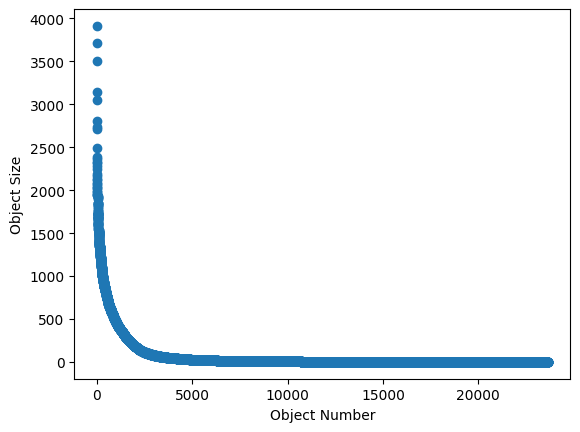

In [1]:
import random as rand
import math

class Object:
    def __init__(self, size = 0, particles_dict = {}):
        self.size = size
        self.particles_dict = particles_dict
        
        
def convert_to_particles(solar_mass):
    return solar_mass * 1.989e30 * 1000 * (1/2.016) * 6.022e23

    
def scale_down(n, scaling_factor):
    return int(n * scaling_factor)

    
#inputs
G_low = 0.8
G_sun = 1
G_high = 1.04
high_dens_vel = 0.7 # need to confirm
low_dens_vel = 0.3 # need to confirm

#current iterations inputs
m = G_low
p = low_dens_vel #probability of collisions
p_ie = 0.5 # probability of inelastic collisions, adjust to realism if possible

#inner variables
n = convert_to_particles(m)  # number of particles
n = scale_down(n, scaling_factor=1e-52) # should be 1e-52
critical_mass_in_particles = 0.08 * n # should be some % of n
total_particles = n + (n * 0.01) # 99% of the cloud is gas and 1% is dust
num_collisions = 0
num_inelastic_collisions = 0
Clock = 0
largest_object_size = 0
objects_dict = {}
seed = 10
rand.seed(seed)

def main_simulation():
    
    event = initialize()
    print("n is ", n, " and total num particles is ", total_particles, " and critical mass is ", critical_mass_in_particles)
    #run the simulation until the largest object in the system reaches the critical mass of the sun
    while largest_object_size < critical_mass_in_particles:
        process_collision(event)
        # create the next event
        event = create_event()
        
    print_stats()

def increment_clock():
    global Clock
    Clock +=  -1 * math.log(rand.random()) / p   


def initialize():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same
        if particle2 != particle1:
            if rand.random() >= p: #a collision occurs
                #increment time between collisions
                increment_clock()
                num_collisions += 1
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
               

def process_collision(event):
    global objects_dict, largest_object_size
    particle1 = event[0] #particle1
    particle2 = event[1] #particle2
    if particle1 not in objects_dict and particle2 not in objects_dict:
        #since the 2 particles have collided, they will form a new object
        new_object = Object(size = 2, particles_dict = {particle1: 1, particle2: 1})
        objects_dict[particle1] = new_object
        largest_object_size = max(largest_object_size, new_object.size)
            
    elif particle1 in objects_dict and particle2 not in objects_dict:
        objects_dict[particle1].size += 1
        objects_dict[particle1].particles_dict[particle2] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle1].size)
            
    elif particle2 in objects_dict and particle1 not in objects_dict:
        objects_dict[particle2].size += 1
        objects_dict[particle2].particles_dict[particle1] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle2].size)
            
    else: #case where both particles are both in the dictionary. We must merge the 2 objects into 1 and delete the smaller object
        #check which object is bigger
        if objects_dict[particle1].size > objects_dict[particle2].size:
            smaller_object = particle2
            bigger_object = particle1
        else:
            smaller_object = particle1
            bigger_object = particle2
        #merge the 2 objects 
        objects_dict[bigger_object].size += objects_dict[smaller_object].size
        #for all objects the smaller object is connected to, add them to the bigger object
        for particle in objects_dict[smaller_object].particles_dict:
            objects_dict[bigger_object].particles_dict[particle] = 1
        #delete the smaller object
        del objects_dict[smaller_object]
        largest_object_size = max(largest_object_size, objects_dict[bigger_object].size)
            


def create_event():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    object_num = find_object(particle1) 
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same, and that particle2 has not already collided with particle1
        if particle2 != particle1 and particle2 not in objects_dict[object_num].particles_dict: 
            if rand.random() >= p: #a collision occurs
                num_collisions += 1
                #increment time between collisions
                increment_clock()
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
        
        
def find_object(particle):
    global objects_dict
    # 3 cases: 
    # 1. particle is not in the dictionary, 
    # 2. particle 1 is in the dictionary as its own object, or 
    # 3. particle 1 is part of a different object's particle_dict
    
    #case 2
    if particle in objects_dict:
        return particle

    #case 3
    #for each object in the dictionary, check if the particle is in some other object's particles_dict
    for obj in objects_dict:
        for num in objects_dict[obj].particles_dict:
            if num == particle:
                return obj
    
    #case 1 particle is not in the dictionary, create and return the object num key
    new_object = Object(size = 1, particles_dict = {particle: 1})
    objects_dict[particle] = new_object
    return particle
    

def print_stats():
    print("Number of collisions: ", num_collisions)
    print("Number of inelastic collisions: ", num_inelastic_collisions)
    print("Time taken to reach critical mass (Clock): ", Clock)
    print("Largest object size: ", largest_object_size)
    
    output_data_li = []
    with open(f"output_for_{m},{p},{seed}.txt", "w") as f:
        for obj in objects_dict:
            output_data_li.append((obj, objects_dict[obj].size))
            
        f.write("Number of collisions: " + str(num_collisions) + "\n")
        f.write("Number of inelastic collisions: " + str(num_inelastic_collisions) + "\n")
        f.write("Time taken to reach critical mass: " + str(Clock) + "\n")
        f.write("Largest object size: " + str(largest_object_size) + "\n")
    
        # sort output_data_li based on size of object, from largest to smallest
        output_data_li.sort(key = lambda x: x[1], reverse = True)
        for sorted_obj in output_data_li:
            f.write(str(sorted_obj[0]) + " " + str(sorted_obj[1]) + "\n")
    
    #plot the data where the x axis is the object number and the y axis is the size of the object
    import matplotlib.pyplot as plt
    x = [i for i in range(len(output_data_li))]
    y = [i[1] for i in output_data_li]
    plt.scatter(x, y)
    plt.xlabel("Object Number")
    plt.ylabel("Object Size")

if __name__ == "__main__":
    main_simulation()


n is  59413  and total num particles is  60007.13  and critical mass is  4753.04
Number of collisions:  4435481
Number of inelastic collisions:  2217585
Time taken to reach critical mass (Clock):  14801740.192935692
Largest object size:  4798


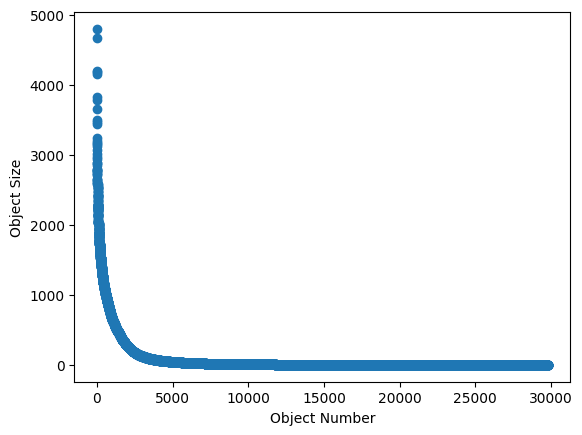

In [2]:
import random as rand
import math

class Object:
    def __init__(self, size = 0, particles_dict = {}):
        self.size = size
        self.particles_dict = particles_dict
        
        
def convert_to_particles(solar_mass):
    return solar_mass * 1.989e30 * 1000 * (1/2.016) * 6.022e23

    
def scale_down(n, scaling_factor):
    return int(n * scaling_factor)

    
#inputs
G_low = 0.8
G_sun = 1
G_high = 1.04
high_dens_vel = 0.7 # need to confirm
low_dens_vel = 0.3 # need to confirm

#current iterations inputs
m = G_sun
p = low_dens_vel #probability of collisions
p_ie = 0.5 # probability of inelastic collisions, adjust to realism if possible

#inner variables
n = convert_to_particles(m)  # number of particles
n = scale_down(n, scaling_factor=1e-52) # should be 1e-52
critical_mass_in_particles = 0.08 * n # should be some % of n
total_particles = n + (n * 0.01) # 99% of the cloud is gas and 1% is dust
num_collisions = 0
num_inelastic_collisions = 0
Clock = 0
largest_object_size = 0
objects_dict = {}
seed = 10
rand.seed(seed)

def main_simulation():
    
    event = initialize()
    print("n is ", n, " and total num particles is ", total_particles, " and critical mass is ", critical_mass_in_particles)
    #run the simulation until the largest object in the system reaches the critical mass of the sun
    while largest_object_size < critical_mass_in_particles:
        process_collision(event)
        # create the next event
        event = create_event()
        
    print_stats()

def increment_clock():
    global Clock
    Clock +=  -1 * math.log(rand.random()) / p   


def initialize():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same
        if particle2 != particle1:
            if rand.random() >= p: #a collision occurs
                #increment time between collisions
                increment_clock()
                num_collisions += 1
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
               

def process_collision(event):
    global objects_dict, largest_object_size
    particle1 = event[0] #particle1
    particle2 = event[1] #particle2
    if particle1 not in objects_dict and particle2 not in objects_dict:
        #since the 2 particles have collided, they will form a new object
        new_object = Object(size = 2, particles_dict = {particle1: 1, particle2: 1})
        objects_dict[particle1] = new_object
        largest_object_size = max(largest_object_size, new_object.size)
            
    elif particle1 in objects_dict and particle2 not in objects_dict:
        objects_dict[particle1].size += 1
        objects_dict[particle1].particles_dict[particle2] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle1].size)
            
    elif particle2 in objects_dict and particle1 not in objects_dict:
        objects_dict[particle2].size += 1
        objects_dict[particle2].particles_dict[particle1] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle2].size)
            
    else: #case where both particles are both in the dictionary. We must merge the 2 objects into 1 and delete the smaller object
        #check which object is bigger
        if objects_dict[particle1].size > objects_dict[particle2].size:
            smaller_object = particle2
            bigger_object = particle1
        else:
            smaller_object = particle1
            bigger_object = particle2
        #merge the 2 objects 
        objects_dict[bigger_object].size += objects_dict[smaller_object].size
        #for all objects the smaller object is connected to, add them to the bigger object
        for particle in objects_dict[smaller_object].particles_dict:
            objects_dict[bigger_object].particles_dict[particle] = 1
        #delete the smaller object
        del objects_dict[smaller_object]
        largest_object_size = max(largest_object_size, objects_dict[bigger_object].size)
            


def create_event():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    object_num = find_object(particle1) 
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same, and that particle2 has not already collided with particle1
        if particle2 != particle1 and particle2 not in objects_dict[object_num].particles_dict: 
            if rand.random() >= p: #a collision occurs
                num_collisions += 1
                #increment time between collisions
                increment_clock()
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
        
        
def find_object(particle):
    global objects_dict
    # 3 cases: 
    # 1. particle is not in the dictionary, 
    # 2. particle 1 is in the dictionary as its own object, or 
    # 3. particle 1 is part of a different object's particle_dict
    
    #case 2
    if particle in objects_dict:
        return particle

    #case 3
    #for each object in the dictionary, check if the particle is in some other object's particles_dict
    for obj in objects_dict:
        for num in objects_dict[obj].particles_dict:
            if num == particle:
                return obj
    
    #case 1 particle is not in the dictionary, create and return the object num key
    new_object = Object(size = 1, particles_dict = {particle: 1})
    objects_dict[particle] = new_object
    return particle
    

def print_stats():
    print("Number of collisions: ", num_collisions)
    print("Number of inelastic collisions: ", num_inelastic_collisions)
    print("Time taken to reach critical mass (Clock): ", Clock)
    print("Largest object size: ", largest_object_size)
    
    output_data_li = []
    with open(f"output_for_{m},{p},{seed}.txt", "w") as f:
        for obj in objects_dict:
            output_data_li.append((obj, objects_dict[obj].size))
            
        f.write("Number of collisions: " + str(num_collisions) + "\n")
        f.write("Number of inelastic collisions: " + str(num_inelastic_collisions) + "\n")
        f.write("Time taken to reach critical mass: " + str(Clock) + "\n")
        f.write("Largest object size: " + str(largest_object_size) + "\n")
    
        # sort output_data_li based on size of object, from largest to smallest
        output_data_li.sort(key = lambda x: x[1], reverse = True)
        for sorted_obj in output_data_li:
            f.write(str(sorted_obj[0]) + " " + str(sorted_obj[1]) + "\n")
    
    #plot the data where the x axis is the object number and the y axis is the size of the object
    import matplotlib.pyplot as plt
    x = [i for i in range(len(output_data_li))]
    y = [i[1] for i in output_data_li]
    plt.scatter(x, y)
    plt.xlabel("Object Number")
    plt.ylabel("Object Size")

if __name__ == "__main__":
    main_simulation()


n is  61790  and total num particles is  62407.9  and critical mass is  4943.2
Number of collisions:  4266386
Number of inelastic collisions:  2134050
Time taken to reach critical mass (Clock):  14232712.985187447
Largest object size:  5308


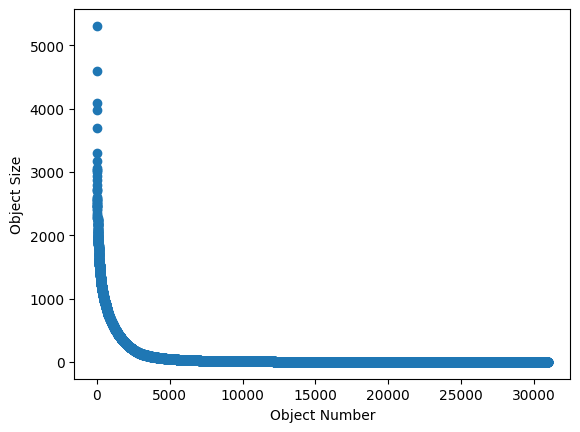

In [3]:
import random as rand
import math

class Object:
    def __init__(self, size = 0, particles_dict = {}):
        self.size = size
        self.particles_dict = particles_dict
        
        
def convert_to_particles(solar_mass):
    return solar_mass * 1.989e30 * 1000 * (1/2.016) * 6.022e23

    
def scale_down(n, scaling_factor):
    return int(n * scaling_factor)

    
#inputs
G_low = 0.8
G_sun = 1
G_high = 1.04
high_dens_vel = 0.7 # need to confirm
low_dens_vel = 0.3 # need to confirm

#current iterations inputs
m = G_high
p = low_dens_vel #probability of collisions
p_ie = 0.5 # probability of inelastic collisions, adjust to realism if possible

#inner variables
n = convert_to_particles(m)  # number of particles
n = scale_down(n, scaling_factor=1e-52) # should be 1e-52
critical_mass_in_particles = 0.08 * n # should be some % of n
total_particles = n + (n * 0.01) # 99% of the cloud is gas and 1% is dust
num_collisions = 0
num_inelastic_collisions = 0
Clock = 0
largest_object_size = 0
objects_dict = {}
seed = 10
rand.seed(seed)

def main_simulation():
    
    event = initialize()
    print("n is ", n, " and total num particles is ", total_particles, " and critical mass is ", critical_mass_in_particles)
    #run the simulation until the largest object in the system reaches the critical mass of the sun
    while largest_object_size < critical_mass_in_particles:
        process_collision(event)
        # create the next event
        event = create_event()
        
    print_stats()

def increment_clock():
    global Clock
    Clock +=  -1 * math.log(rand.random()) / p   


def initialize():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same
        if particle2 != particle1:
            if rand.random() >= p: #a collision occurs
                #increment time between collisions
                increment_clock()
                num_collisions += 1
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
               

def process_collision(event):
    global objects_dict, largest_object_size
    particle1 = event[0] #particle1
    particle2 = event[1] #particle2
    if particle1 not in objects_dict and particle2 not in objects_dict:
        #since the 2 particles have collided, they will form a new object
        new_object = Object(size = 2, particles_dict = {particle1: 1, particle2: 1})
        objects_dict[particle1] = new_object
        largest_object_size = max(largest_object_size, new_object.size)
            
    elif particle1 in objects_dict and particle2 not in objects_dict:
        objects_dict[particle1].size += 1
        objects_dict[particle1].particles_dict[particle2] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle1].size)
            
    elif particle2 in objects_dict and particle1 not in objects_dict:
        objects_dict[particle2].size += 1
        objects_dict[particle2].particles_dict[particle1] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle2].size)
            
    else: #case where both particles are both in the dictionary. We must merge the 2 objects into 1 and delete the smaller object
        #check which object is bigger
        if objects_dict[particle1].size > objects_dict[particle2].size:
            smaller_object = particle2
            bigger_object = particle1
        else:
            smaller_object = particle1
            bigger_object = particle2
        #merge the 2 objects 
        objects_dict[bigger_object].size += objects_dict[smaller_object].size
        #for all objects the smaller object is connected to, add them to the bigger object
        for particle in objects_dict[smaller_object].particles_dict:
            objects_dict[bigger_object].particles_dict[particle] = 1
        #delete the smaller object
        del objects_dict[smaller_object]
        largest_object_size = max(largest_object_size, objects_dict[bigger_object].size)
            


def create_event():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    object_num = find_object(particle1) 
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same, and that particle2 has not already collided with particle1
        if particle2 != particle1 and particle2 not in objects_dict[object_num].particles_dict: 
            if rand.random() >= p: #a collision occurs
                num_collisions += 1
                #increment time between collisions
                increment_clock()
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
        
        
def find_object(particle):
    global objects_dict
    # 3 cases: 
    # 1. particle is not in the dictionary, 
    # 2. particle 1 is in the dictionary as its own object, or 
    # 3. particle 1 is part of a different object's particle_dict
    
    #case 2
    if particle in objects_dict:
        return particle

    #case 3
    #for each object in the dictionary, check if the particle is in some other object's particles_dict
    for obj in objects_dict:
        for num in objects_dict[obj].particles_dict:
            if num == particle:
                return obj
    
    #case 1 particle is not in the dictionary, create and return the object num key
    new_object = Object(size = 1, particles_dict = {particle: 1})
    objects_dict[particle] = new_object
    return particle
    

def print_stats():
    print("Number of collisions: ", num_collisions)
    print("Number of inelastic collisions: ", num_inelastic_collisions)
    print("Time taken to reach critical mass (Clock): ", Clock)
    print("Largest object size: ", largest_object_size)
    
    output_data_li = []
    with open(f"output_for_{m},{p},{seed}.txt", "w") as f:
        for obj in objects_dict:
            output_data_li.append((obj, objects_dict[obj].size))
            
        f.write("Number of collisions: " + str(num_collisions) + "\n")
        f.write("Number of inelastic collisions: " + str(num_inelastic_collisions) + "\n")
        f.write("Time taken to reach critical mass: " + str(Clock) + "\n")
        f.write("Largest object size: " + str(largest_object_size) + "\n")
    
        # sort output_data_li based on size of object, from largest to smallest
        output_data_li.sort(key = lambda x: x[1], reverse = True)
        for sorted_obj in output_data_li:
            f.write(str(sorted_obj[0]) + " " + str(sorted_obj[1]) + "\n")
    
    #plot the data where the x axis is the object number and the y axis is the size of the object
    import matplotlib.pyplot as plt
    x = [i for i in range(len(output_data_li))]
    y = [i[1] for i in output_data_li]
    plt.scatter(x, y)
    plt.xlabel("Object Number")
    plt.ylabel("Object Size")

if __name__ == "__main__":
    main_simulation()


n is  47530  and total num particles is  48005.3  and critical mass is  3802.4
Number of collisions:  2660839
Number of inelastic collisions:  1329886
Time taken to reach critical mass (Clock):  8867094.320413908
Largest object size:  3803


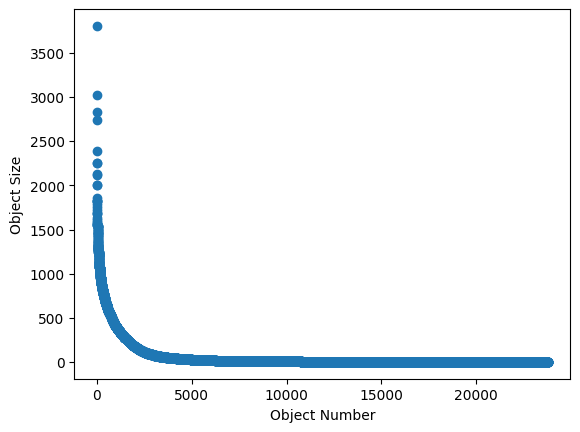

In [1]:
import random as rand
import math

class Object:
    def __init__(self, size = 0, particles_dict = {}):
        self.size = size
        self.particles_dict = particles_dict
        
        
def convert_to_particles(solar_mass):
    return solar_mass * 1.989e30 * 1000 * (1/2.016) * 6.022e23

    
def scale_down(n, scaling_factor):
    return int(n * scaling_factor)

    
#inputs
G_low = 0.8
G_sun = 1
G_high = 1.04
high_dens_vel = 0.7 # need to confirm
low_dens_vel = 0.3 # need to confirm

#current iterations inputs
m = G_low
p = low_dens_vel #probability of collisions
p_ie = 0.5 # probability of inelastic collisions, adjust to realism if possible

#inner variables
n = convert_to_particles(m)  # number of particles
n = scale_down(n, scaling_factor=1e-52) # should be 1e-52
critical_mass_in_particles = 0.08 * n # should be some % of n
total_particles = n + (n * 0.01) # 99% of the cloud is gas and 1% is dust
num_collisions = 0
num_inelastic_collisions = 0
Clock = 0
largest_object_size = 0
objects_dict = {}
seed = 11
rand.seed(seed)

def main_simulation():
    
    event = initialize()
    print("n is ", n, " and total num particles is ", total_particles, " and critical mass is ", critical_mass_in_particles)
    #run the simulation until the largest object in the system reaches the critical mass of the sun
    while largest_object_size < critical_mass_in_particles:
        process_collision(event)
        # create the next event
        event = create_event()
        
    print_stats()

def increment_clock():
    global Clock
    Clock +=  -1 * math.log(rand.random()) / p   


def initialize():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same
        if particle2 != particle1:
            if rand.random() >= p: #a collision occurs
                #increment time between collisions
                increment_clock()
                num_collisions += 1
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
               

def process_collision(event):
    global objects_dict, largest_object_size
    particle1 = event[0] #particle1
    particle2 = event[1] #particle2
    if particle1 not in objects_dict and particle2 not in objects_dict:
        #since the 2 particles have collided, they will form a new object
        new_object = Object(size = 2, particles_dict = {particle1: 1, particle2: 1})
        objects_dict[particle1] = new_object
        largest_object_size = max(largest_object_size, new_object.size)
            
    elif particle1 in objects_dict and particle2 not in objects_dict:
        objects_dict[particle1].size += 1
        objects_dict[particle1].particles_dict[particle2] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle1].size)
            
    elif particle2 in objects_dict and particle1 not in objects_dict:
        objects_dict[particle2].size += 1
        objects_dict[particle2].particles_dict[particle1] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle2].size)
            
    else: #case where both particles are both in the dictionary. We must merge the 2 objects into 1 and delete the smaller object
        #check which object is bigger
        if objects_dict[particle1].size > objects_dict[particle2].size:
            smaller_object = particle2
            bigger_object = particle1
        else:
            smaller_object = particle1
            bigger_object = particle2
        #merge the 2 objects 
        objects_dict[bigger_object].size += objects_dict[smaller_object].size
        #for all objects the smaller object is connected to, add them to the bigger object
        for particle in objects_dict[smaller_object].particles_dict:
            objects_dict[bigger_object].particles_dict[particle] = 1
        #delete the smaller object
        del objects_dict[smaller_object]
        largest_object_size = max(largest_object_size, objects_dict[bigger_object].size)
            


def create_event():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    object_num = find_object(particle1) 
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same, and that particle2 has not already collided with particle1
        if particle2 != particle1 and particle2 not in objects_dict[object_num].particles_dict: 
            if rand.random() >= p: #a collision occurs
                num_collisions += 1
                #increment time between collisions
                increment_clock()
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
        
        
def find_object(particle):
    global objects_dict
    # 3 cases: 
    # 1. particle is not in the dictionary, 
    # 2. particle 1 is in the dictionary as its own object, or 
    # 3. particle 1 is part of a different object's particle_dict
    
    #case 2
    if particle in objects_dict:
        return particle

    #case 3
    #for each object in the dictionary, check if the particle is in some other object's particles_dict
    for obj in objects_dict:
        for num in objects_dict[obj].particles_dict:
            if num == particle:
                return obj
    
    #case 1 particle is not in the dictionary, create and return the object num key
    new_object = Object(size = 1, particles_dict = {particle: 1})
    objects_dict[particle] = new_object
    return particle
    

def print_stats():
    print("Number of collisions: ", num_collisions)
    print("Number of inelastic collisions: ", num_inelastic_collisions)
    print("Time taken to reach critical mass (Clock): ", Clock)
    print("Largest object size: ", largest_object_size)
    
    output_data_li = []
    with open(f"output_for_{m},{p},{seed}.txt", "w") as f:
        for obj in objects_dict:
            output_data_li.append((obj, objects_dict[obj].size))
            
        f.write("Number of collisions: " + str(num_collisions) + "\n")
        f.write("Number of inelastic collisions: " + str(num_inelastic_collisions) + "\n")
        f.write("Time taken to reach critical mass: " + str(Clock) + "\n")
        f.write("Largest object size: " + str(largest_object_size) + "\n")
    
        # sort output_data_li based on size of object, from largest to smallest
        output_data_li.sort(key = lambda x: x[1], reverse = True)
        for sorted_obj in output_data_li:
            f.write(str(sorted_obj[0]) + " " + str(sorted_obj[1]) + "\n")
    
    #plot the data where the x axis is the object number and the y axis is the size of the object
    import matplotlib.pyplot as plt
    x = [i for i in range(len(output_data_li))]
    y = [i[1] for i in output_data_li]
    plt.scatter(x, y)
    plt.xlabel("Object Number")
    plt.ylabel("Object Size")

if __name__ == "__main__":
    main_simulation()


In [ ]:
import random as rand
import math

class Object:
    def __init__(self, size = 0, particles_dict = {}):
        self.size = size
        self.particles_dict = particles_dict
        
        
def convert_to_particles(solar_mass):
    return solar_mass * 1.989e30 * 1000 * (1/2.016) * 6.022e23

    
def scale_down(n, scaling_factor):
    return int(n * scaling_factor)

    
#inputs
G_low = 0.8
G_sun = 1
G_high = 1.04
high_dens_vel = 0.7 # need to confirm
low_dens_vel = 0.3 # need to confirm

#current iterations inputs
m = G_low
p = low_dens_vel #probability of collisions
p_ie = 0.5 # probability of inelastic collisions, adjust to realism if possible

#inner variables
n = convert_to_particles(m)  # number of particles
n = scale_down(n, scaling_factor=1e-52) # should be 1e-52
critical_mass_in_particles = 0.08 * n # should be some % of n
total_particles = n + (n * 0.01) # 99% of the cloud is gas and 1% is dust
num_collisions = 0
num_inelastic_collisions = 0
Clock = 0
largest_object_size = 0
objects_dict = {}
seed = 12
rand.seed(seed)

def main_simulation():
    
    event = initialize()
    print("n is ", n, " and total num particles is ", total_particles, " and critical mass is ", critical_mass_in_particles)
    #run the simulation until the largest object in the system reaches the critical mass of the sun
    while largest_object_size < critical_mass_in_particles:
        process_collision(event)
        # create the next event
        event = create_event()
        
    print_stats()

def increment_clock():
    global Clock
    Clock +=  -1 * math.log(rand.random()) / p   


def initialize():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same
        if particle2 != particle1:
            if rand.random() >= p: #a collision occurs
                #increment time between collisions
                increment_clock()
                num_collisions += 1
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
               

def process_collision(event):
    global objects_dict, largest_object_size
    particle1 = event[0] #particle1
    particle2 = event[1] #particle2
    if particle1 not in objects_dict and particle2 not in objects_dict:
        #since the 2 particles have collided, they will form a new object
        new_object = Object(size = 2, particles_dict = {particle1: 1, particle2: 1})
        objects_dict[particle1] = new_object
        largest_object_size = max(largest_object_size, new_object.size)
            
    elif particle1 in objects_dict and particle2 not in objects_dict:
        objects_dict[particle1].size += 1
        objects_dict[particle1].particles_dict[particle2] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle1].size)
            
    elif particle2 in objects_dict and particle1 not in objects_dict:
        objects_dict[particle2].size += 1
        objects_dict[particle2].particles_dict[particle1] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle2].size)
            
    else: #case where both particles are both in the dictionary. We must merge the 2 objects into 1 and delete the smaller object
        #check which object is bigger
        if objects_dict[particle1].size > objects_dict[particle2].size:
            smaller_object = particle2
            bigger_object = particle1
        else:
            smaller_object = particle1
            bigger_object = particle2
        #merge the 2 objects 
        objects_dict[bigger_object].size += objects_dict[smaller_object].size
        #for all objects the smaller object is connected to, add them to the bigger object
        for particle in objects_dict[smaller_object].particles_dict:
            objects_dict[bigger_object].particles_dict[particle] = 1
        #delete the smaller object
        del objects_dict[smaller_object]
        largest_object_size = max(largest_object_size, objects_dict[bigger_object].size)
            


def create_event():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    object_num = find_object(particle1) 
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same, and that particle2 has not already collided with particle1
        if particle2 != particle1 and particle2 not in objects_dict[object_num].particles_dict: 
            if rand.random() >= p: #a collision occurs
                num_collisions += 1
                #increment time between collisions
                increment_clock()
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
        
        
def find_object(particle):
    global objects_dict
    # 3 cases: 
    # 1. particle is not in the dictionary, 
    # 2. particle 1 is in the dictionary as its own object, or 
    # 3. particle 1 is part of a different object's particle_dict
    
    #case 2
    if particle in objects_dict:
        return particle

    #case 3
    #for each object in the dictionary, check if the particle is in some other object's particles_dict
    for obj in objects_dict:
        for num in objects_dict[obj].particles_dict:
            if num == particle:
                return obj
    
    #case 1 particle is not in the dictionary, create and return the object num key
    new_object = Object(size = 1, particles_dict = {particle: 1})
    objects_dict[particle] = new_object
    return particle
    

def print_stats():
    print("Number of collisions: ", num_collisions)
    print("Number of inelastic collisions: ", num_inelastic_collisions)
    print("Time taken to reach critical mass (Clock): ", Clock)
    print("Largest object size: ", largest_object_size)
    
    output_data_li = []
    with open(f"output_for_{m},{p},{seed}.txt", "w") as f:
        for obj in objects_dict:
            output_data_li.append((obj, objects_dict[obj].size))
            
        f.write("Number of collisions: " + str(num_collisions) + "\n")
        f.write("Number of inelastic collisions: " + str(num_inelastic_collisions) + "\n")
        f.write("Time taken to reach critical mass: " + str(Clock) + "\n")
        f.write("Largest object size: " + str(largest_object_size) + "\n")
    
        # sort output_data_li based on size of object, from largest to smallest
        output_data_li.sort(key = lambda x: x[1], reverse = True)
        for sorted_obj in output_data_li:
            f.write(str(sorted_obj[0]) + " " + str(sorted_obj[1]) + "\n")
    
    #plot the data where the x axis is the object number and the y axis is the size of the object
    import matplotlib.pyplot as plt
    x = [i for i in range(len(output_data_li))]
    y = [i[1] for i in output_data_li]
    plt.scatter(x, y)
    plt.xlabel("Object Number")
    plt.ylabel("Object Size")

if __name__ == "__main__":
    main_simulation()


n is  47530  and total num particles is  48005.3  and critical mass is  3802.4


In [ ]:
import random as rand
import math

class Object:
    def __init__(self, size = 0, particles_dict = {}):
        self.size = size
        self.particles_dict = particles_dict
        
        
def convert_to_particles(solar_mass):
    return solar_mass * 1.989e30 * 1000 * (1/2.016) * 6.022e23

    
def scale_down(n, scaling_factor):
    return int(n * scaling_factor)

    
#inputs
G_low = 0.8
G_sun = 1
G_high = 1.04
high_dens_vel = 0.7 # need to confirm
low_dens_vel = 0.3 # need to confirm

#current iterations inputs
m = G_low
p = low_dens_vel #probability of collisions
p_ie = 0.5 # probability of inelastic collisions, adjust to realism if possible

#inner variables
n = convert_to_particles(m)  # number of particles
n = scale_down(n, scaling_factor=1e-52) # should be 1e-52
critical_mass_in_particles = 0.08 * n # should be some % of n
total_particles = n + (n * 0.01) # 99% of the cloud is gas and 1% is dust
num_collisions = 0
num_inelastic_collisions = 0
Clock = 0
largest_object_size = 0
objects_dict = {}
seed = 13
rand.seed(seed)

def main_simulation():
    
    event = initialize()
    print("n is ", n, " and total num particles is ", total_particles, " and critical mass is ", critical_mass_in_particles)
    #run the simulation until the largest object in the system reaches the critical mass of the sun
    while largest_object_size < critical_mass_in_particles:
        process_collision(event)
        # create the next event
        event = create_event()
        
    print_stats()

def increment_clock():
    global Clock
    Clock +=  -1 * math.log(rand.random()) / p   


def initialize():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same
        if particle2 != particle1:
            if rand.random() >= p: #a collision occurs
                #increment time between collisions
                increment_clock()
                num_collisions += 1
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
               

def process_collision(event):
    global objects_dict, largest_object_size
    particle1 = event[0] #particle1
    particle2 = event[1] #particle2
    if particle1 not in objects_dict and particle2 not in objects_dict:
        #since the 2 particles have collided, they will form a new object
        new_object = Object(size = 2, particles_dict = {particle1: 1, particle2: 1})
        objects_dict[particle1] = new_object
        largest_object_size = max(largest_object_size, new_object.size)
            
    elif particle1 in objects_dict and particle2 not in objects_dict:
        objects_dict[particle1].size += 1
        objects_dict[particle1].particles_dict[particle2] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle1].size)
            
    elif particle2 in objects_dict and particle1 not in objects_dict:
        objects_dict[particle2].size += 1
        objects_dict[particle2].particles_dict[particle1] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle2].size)
            
    else: #case where both particles are both in the dictionary. We must merge the 2 objects into 1 and delete the smaller object
        #check which object is bigger
        if objects_dict[particle1].size > objects_dict[particle2].size:
            smaller_object = particle2
            bigger_object = particle1
        else:
            smaller_object = particle1
            bigger_object = particle2
        #merge the 2 objects 
        objects_dict[bigger_object].size += objects_dict[smaller_object].size
        #for all objects the smaller object is connected to, add them to the bigger object
        for particle in objects_dict[smaller_object].particles_dict:
            objects_dict[bigger_object].particles_dict[particle] = 1
        #delete the smaller object
        del objects_dict[smaller_object]
        largest_object_size = max(largest_object_size, objects_dict[bigger_object].size)
            


def create_event():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    object_num = find_object(particle1) 
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same, and that particle2 has not already collided with particle1
        if particle2 != particle1 and particle2 not in objects_dict[object_num].particles_dict: 
            if rand.random() >= p: #a collision occurs
                num_collisions += 1
                #increment time between collisions
                increment_clock()
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
        
        
def find_object(particle):
    global objects_dict
    # 3 cases: 
    # 1. particle is not in the dictionary, 
    # 2. particle 1 is in the dictionary as its own object, or 
    # 3. particle 1 is part of a different object's particle_dict
    
    #case 2
    if particle in objects_dict:
        return particle

    #case 3
    #for each object in the dictionary, check if the particle is in some other object's particles_dict
    for obj in objects_dict:
        for num in objects_dict[obj].particles_dict:
            if num == particle:
                return obj
    
    #case 1 particle is not in the dictionary, create and return the object num key
    new_object = Object(size = 1, particles_dict = {particle: 1})
    objects_dict[particle] = new_object
    return particle
    

def print_stats():
    print("Number of collisions: ", num_collisions)
    print("Number of inelastic collisions: ", num_inelastic_collisions)
    print("Time taken to reach critical mass (Clock): ", Clock)
    print("Largest object size: ", largest_object_size)
    
    output_data_li = []
    with open(f"output_for_{m},{p},{seed}.txt", "w") as f:
        for obj in objects_dict:
            output_data_li.append((obj, objects_dict[obj].size))
            
        f.write("Number of collisions: " + str(num_collisions) + "\n")
        f.write("Number of inelastic collisions: " + str(num_inelastic_collisions) + "\n")
        f.write("Time taken to reach critical mass: " + str(Clock) + "\n")
        f.write("Largest object size: " + str(largest_object_size) + "\n")
    
        # sort output_data_li based on size of object, from largest to smallest
        output_data_li.sort(key = lambda x: x[1], reverse = True)
        for sorted_obj in output_data_li:
            f.write(str(sorted_obj[0]) + " " + str(sorted_obj[1]) + "\n")
    
    #plot the data where the x axis is the object number and the y axis is the size of the object
    import matplotlib.pyplot as plt
    x = [i for i in range(len(output_data_li))]
    y = [i[1] for i in output_data_li]
    plt.scatter(x, y)
    plt.xlabel("Object Number")
    plt.ylabel("Object Size")

if __name__ == "__main__":
    main_simulation()


In [ ]:
import random as rand
import math

class Object:
    def __init__(self, size = 0, particles_dict = {}):
        self.size = size
        self.particles_dict = particles_dict
        
        
def convert_to_particles(solar_mass):
    return solar_mass * 1.989e30 * 1000 * (1/2.016) * 6.022e23

    
def scale_down(n, scaling_factor):
    return int(n * scaling_factor)

    
#inputs
G_low = 0.8
G_sun = 1
G_high = 1.04
high_dens_vel = 0.7 # need to confirm
low_dens_vel = 0.3 # need to confirm

#current iterations inputs
m = G_low
p = low_dens_vel #probability of collisions
p_ie = 0.5 # probability of inelastic collisions, adjust to realism if possible

#inner variables
n = convert_to_particles(m)  # number of particles
n = scale_down(n, scaling_factor=1e-52) # should be 1e-52
critical_mass_in_particles = 0.08 * n # should be some % of n
total_particles = n + (n * 0.01) # 99% of the cloud is gas and 1% is dust
num_collisions = 0
num_inelastic_collisions = 0
Clock = 0
largest_object_size = 0
objects_dict = {}
seed = 14
rand.seed(seed)

def main_simulation():
    
    event = initialize()
    print("n is ", n, " and total num particles is ", total_particles, " and critical mass is ", critical_mass_in_particles)
    #run the simulation until the largest object in the system reaches the critical mass of the sun
    while largest_object_size < critical_mass_in_particles:
        process_collision(event)
        # create the next event
        event = create_event()
        
    print_stats()

def increment_clock():
    global Clock
    Clock +=  -1 * math.log(rand.random()) / p   


def initialize():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same
        if particle2 != particle1:
            if rand.random() >= p: #a collision occurs
                #increment time between collisions
                increment_clock()
                num_collisions += 1
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
               

def process_collision(event):
    global objects_dict, largest_object_size
    particle1 = event[0] #particle1
    particle2 = event[1] #particle2
    if particle1 not in objects_dict and particle2 not in objects_dict:
        #since the 2 particles have collided, they will form a new object
        new_object = Object(size = 2, particles_dict = {particle1: 1, particle2: 1})
        objects_dict[particle1] = new_object
        largest_object_size = max(largest_object_size, new_object.size)
            
    elif particle1 in objects_dict and particle2 not in objects_dict:
        objects_dict[particle1].size += 1
        objects_dict[particle1].particles_dict[particle2] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle1].size)
            
    elif particle2 in objects_dict and particle1 not in objects_dict:
        objects_dict[particle2].size += 1
        objects_dict[particle2].particles_dict[particle1] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle2].size)
            
    else: #case where both particles are both in the dictionary. We must merge the 2 objects into 1 and delete the smaller object
        #check which object is bigger
        if objects_dict[particle1].size > objects_dict[particle2].size:
            smaller_object = particle2
            bigger_object = particle1
        else:
            smaller_object = particle1
            bigger_object = particle2
        #merge the 2 objects 
        objects_dict[bigger_object].size += objects_dict[smaller_object].size
        #for all objects the smaller object is connected to, add them to the bigger object
        for particle in objects_dict[smaller_object].particles_dict:
            objects_dict[bigger_object].particles_dict[particle] = 1
        #delete the smaller object
        del objects_dict[smaller_object]
        largest_object_size = max(largest_object_size, objects_dict[bigger_object].size)
            


def create_event():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    object_num = find_object(particle1) 
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same, and that particle2 has not already collided with particle1
        if particle2 != particle1 and particle2 not in objects_dict[object_num].particles_dict: 
            if rand.random() >= p: #a collision occurs
                num_collisions += 1
                #increment time between collisions
                increment_clock()
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
        
        
def find_object(particle):
    global objects_dict
    # 3 cases: 
    # 1. particle is not in the dictionary, 
    # 2. particle 1 is in the dictionary as its own object, or 
    # 3. particle 1 is part of a different object's particle_dict
    
    #case 2
    if particle in objects_dict:
        return particle

    #case 3
    #for each object in the dictionary, check if the particle is in some other object's particles_dict
    for obj in objects_dict:
        for num in objects_dict[obj].particles_dict:
            if num == particle:
                return obj
    
    #case 1 particle is not in the dictionary, create and return the object num key
    new_object = Object(size = 1, particles_dict = {particle: 1})
    objects_dict[particle] = new_object
    return particle
    

def print_stats():
    print("Number of collisions: ", num_collisions)
    print("Number of inelastic collisions: ", num_inelastic_collisions)
    print("Time taken to reach critical mass (Clock): ", Clock)
    print("Largest object size: ", largest_object_size)
    
    output_data_li = []
    with open(f"output_for_{m},{p},{seed}.txt", "w") as f:
        for obj in objects_dict:
            output_data_li.append((obj, objects_dict[obj].size))
            
        f.write("Number of collisions: " + str(num_collisions) + "\n")
        f.write("Number of inelastic collisions: " + str(num_inelastic_collisions) + "\n")
        f.write("Time taken to reach critical mass: " + str(Clock) + "\n")
        f.write("Largest object size: " + str(largest_object_size) + "\n")
    
        # sort output_data_li based on size of object, from largest to smallest
        output_data_li.sort(key = lambda x: x[1], reverse = True)
        for sorted_obj in output_data_li:
            f.write(str(sorted_obj[0]) + " " + str(sorted_obj[1]) + "\n")
    
    #plot the data where the x axis is the object number and the y axis is the size of the object
    import matplotlib.pyplot as plt
    x = [i for i in range(len(output_data_li))]
    y = [i[1] for i in output_data_li]
    plt.scatter(x, y)
    plt.xlabel("Object Number")
    plt.ylabel("Object Size")

if __name__ == "__main__":
    main_simulation()


In [ ]:
import random as rand
import math

class Object:
    def __init__(self, size = 0, particles_dict = {}):
        self.size = size
        self.particles_dict = particles_dict
        
        
def convert_to_particles(solar_mass):
    return solar_mass * 1.989e30 * 1000 * (1/2.016) * 6.022e23

    
def scale_down(n, scaling_factor):
    return int(n * scaling_factor)

    
#inputs
G_low = 0.8
G_sun = 1
G_high = 1.04
high_dens_vel = 0.7 # need to confirm
low_dens_vel = 0.3 # need to confirm

#current iterations inputs
m = G_sun
p = low_dens_vel #probability of collisions
p_ie = 0.5 # probability of inelastic collisions, adjust to realism if possible

#inner variables
n = convert_to_particles(m)  # number of particles
n = scale_down(n, scaling_factor=1e-52) # should be 1e-52
critical_mass_in_particles = 0.08 * n # should be some % of n
total_particles = n + (n * 0.01) # 99% of the cloud is gas and 1% is dust
num_collisions = 0
num_inelastic_collisions = 0
Clock = 0
largest_object_size = 0
objects_dict = {}
seed = 11
rand.seed(seed)

def main_simulation():
    
    event = initialize()
    print("n is ", n, " and total num particles is ", total_particles, " and critical mass is ", critical_mass_in_particles)
    #run the simulation until the largest object in the system reaches the critical mass of the sun
    while largest_object_size < critical_mass_in_particles:
        process_collision(event)
        # create the next event
        event = create_event()
        
    print_stats()

def increment_clock():
    global Clock
    Clock +=  -1 * math.log(rand.random()) / p   


def initialize():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same
        if particle2 != particle1:
            if rand.random() >= p: #a collision occurs
                #increment time between collisions
                increment_clock()
                num_collisions += 1
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
               

def process_collision(event):
    global objects_dict, largest_object_size
    particle1 = event[0] #particle1
    particle2 = event[1] #particle2
    if particle1 not in objects_dict and particle2 not in objects_dict:
        #since the 2 particles have collided, they will form a new object
        new_object = Object(size = 2, particles_dict = {particle1: 1, particle2: 1})
        objects_dict[particle1] = new_object
        largest_object_size = max(largest_object_size, new_object.size)
            
    elif particle1 in objects_dict and particle2 not in objects_dict:
        objects_dict[particle1].size += 1
        objects_dict[particle1].particles_dict[particle2] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle1].size)
            
    elif particle2 in objects_dict and particle1 not in objects_dict:
        objects_dict[particle2].size += 1
        objects_dict[particle2].particles_dict[particle1] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle2].size)
            
    else: #case where both particles are both in the dictionary. We must merge the 2 objects into 1 and delete the smaller object
        #check which object is bigger
        if objects_dict[particle1].size > objects_dict[particle2].size:
            smaller_object = particle2
            bigger_object = particle1
        else:
            smaller_object = particle1
            bigger_object = particle2
        #merge the 2 objects 
        objects_dict[bigger_object].size += objects_dict[smaller_object].size
        #for all objects the smaller object is connected to, add them to the bigger object
        for particle in objects_dict[smaller_object].particles_dict:
            objects_dict[bigger_object].particles_dict[particle] = 1
        #delete the smaller object
        del objects_dict[smaller_object]
        largest_object_size = max(largest_object_size, objects_dict[bigger_object].size)
            


def create_event():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    object_num = find_object(particle1) 
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same, and that particle2 has not already collided with particle1
        if particle2 != particle1 and particle2 not in objects_dict[object_num].particles_dict: 
            if rand.random() >= p: #a collision occurs
                num_collisions += 1
                #increment time between collisions
                increment_clock()
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
        
        
def find_object(particle):
    global objects_dict
    # 3 cases: 
    # 1. particle is not in the dictionary, 
    # 2. particle 1 is in the dictionary as its own object, or 
    # 3. particle 1 is part of a different object's particle_dict
    
    #case 2
    if particle in objects_dict:
        return particle

    #case 3
    #for each object in the dictionary, check if the particle is in some other object's particles_dict
    for obj in objects_dict:
        for num in objects_dict[obj].particles_dict:
            if num == particle:
                return obj
    
    #case 1 particle is not in the dictionary, create and return the object num key
    new_object = Object(size = 1, particles_dict = {particle: 1})
    objects_dict[particle] = new_object
    return particle
    

def print_stats():
    print("Number of collisions: ", num_collisions)
    print("Number of inelastic collisions: ", num_inelastic_collisions)
    print("Time taken to reach critical mass (Clock): ", Clock)
    print("Largest object size: ", largest_object_size)
    
    output_data_li = []
    with open(f"output_for_{m},{p},{seed}.txt", "w") as f:
        for obj in objects_dict:
            output_data_li.append((obj, objects_dict[obj].size))
            
        f.write("Number of collisions: " + str(num_collisions) + "\n")
        f.write("Number of inelastic collisions: " + str(num_inelastic_collisions) + "\n")
        f.write("Time taken to reach critical mass: " + str(Clock) + "\n")
        f.write("Largest object size: " + str(largest_object_size) + "\n")
    
        # sort output_data_li based on size of object, from largest to smallest
        output_data_li.sort(key = lambda x: x[1], reverse = True)
        for sorted_obj in output_data_li:
            f.write(str(sorted_obj[0]) + " " + str(sorted_obj[1]) + "\n")
    
    #plot the data where the x axis is the object number and the y axis is the size of the object
    import matplotlib.pyplot as plt
    x = [i for i in range(len(output_data_li))]
    y = [i[1] for i in output_data_li]
    plt.scatter(x, y)
    plt.xlabel("Object Number")
    plt.ylabel("Object Size")

if __name__ == "__main__":
    main_simulation()


In [ ]:
import random as rand
import math

class Object:
    def __init__(self, size = 0, particles_dict = {}):
        self.size = size
        self.particles_dict = particles_dict
        
        
def convert_to_particles(solar_mass):
    return solar_mass * 1.989e30 * 1000 * (1/2.016) * 6.022e23

    
def scale_down(n, scaling_factor):
    return int(n * scaling_factor)

    
#inputs
G_low = 0.8
G_sun = 1
G_high = 1.04
high_dens_vel = 0.7 # need to confirm
low_dens_vel = 0.3 # need to confirm

#current iterations inputs
m = G_sun
p = low_dens_vel #probability of collisions
p_ie = 0.5 # probability of inelastic collisions, adjust to realism if possible

#inner variables
n = convert_to_particles(m)  # number of particles
n = scale_down(n, scaling_factor=1e-52) # should be 1e-52
critical_mass_in_particles = 0.08 * n # should be some % of n
total_particles = n + (n * 0.01) # 99% of the cloud is gas and 1% is dust
num_collisions = 0
num_inelastic_collisions = 0
Clock = 0
largest_object_size = 0
objects_dict = {}
seed = 12
rand.seed(seed)

def main_simulation():
    
    event = initialize()
    print("n is ", n, " and total num particles is ", total_particles, " and critical mass is ", critical_mass_in_particles)
    #run the simulation until the largest object in the system reaches the critical mass of the sun
    while largest_object_size < critical_mass_in_particles:
        process_collision(event)
        # create the next event
        event = create_event()
        
    print_stats()

def increment_clock():
    global Clock
    Clock +=  -1 * math.log(rand.random()) / p   


def initialize():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same
        if particle2 != particle1:
            if rand.random() >= p: #a collision occurs
                #increment time between collisions
                increment_clock()
                num_collisions += 1
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
               

def process_collision(event):
    global objects_dict, largest_object_size
    particle1 = event[0] #particle1
    particle2 = event[1] #particle2
    if particle1 not in objects_dict and particle2 not in objects_dict:
        #since the 2 particles have collided, they will form a new object
        new_object = Object(size = 2, particles_dict = {particle1: 1, particle2: 1})
        objects_dict[particle1] = new_object
        largest_object_size = max(largest_object_size, new_object.size)
            
    elif particle1 in objects_dict and particle2 not in objects_dict:
        objects_dict[particle1].size += 1
        objects_dict[particle1].particles_dict[particle2] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle1].size)
            
    elif particle2 in objects_dict and particle1 not in objects_dict:
        objects_dict[particle2].size += 1
        objects_dict[particle2].particles_dict[particle1] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle2].size)
            
    else: #case where both particles are both in the dictionary. We must merge the 2 objects into 1 and delete the smaller object
        #check which object is bigger
        if objects_dict[particle1].size > objects_dict[particle2].size:
            smaller_object = particle2
            bigger_object = particle1
        else:
            smaller_object = particle1
            bigger_object = particle2
        #merge the 2 objects 
        objects_dict[bigger_object].size += objects_dict[smaller_object].size
        #for all objects the smaller object is connected to, add them to the bigger object
        for particle in objects_dict[smaller_object].particles_dict:
            objects_dict[bigger_object].particles_dict[particle] = 1
        #delete the smaller object
        del objects_dict[smaller_object]
        largest_object_size = max(largest_object_size, objects_dict[bigger_object].size)
            


def create_event():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    object_num = find_object(particle1) 
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same, and that particle2 has not already collided with particle1
        if particle2 != particle1 and particle2 not in objects_dict[object_num].particles_dict: 
            if rand.random() >= p: #a collision occurs
                num_collisions += 1
                #increment time between collisions
                increment_clock()
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
        
        
def find_object(particle):
    global objects_dict
    # 3 cases: 
    # 1. particle is not in the dictionary, 
    # 2. particle 1 is in the dictionary as its own object, or 
    # 3. particle 1 is part of a different object's particle_dict
    
    #case 2
    if particle in objects_dict:
        return particle

    #case 3
    #for each object in the dictionary, check if the particle is in some other object's particles_dict
    for obj in objects_dict:
        for num in objects_dict[obj].particles_dict:
            if num == particle:
                return obj
    
    #case 1 particle is not in the dictionary, create and return the object num key
    new_object = Object(size = 1, particles_dict = {particle: 1})
    objects_dict[particle] = new_object
    return particle
    

def print_stats():
    print("Number of collisions: ", num_collisions)
    print("Number of inelastic collisions: ", num_inelastic_collisions)
    print("Time taken to reach critical mass (Clock): ", Clock)
    print("Largest object size: ", largest_object_size)
    
    output_data_li = []
    with open(f"output_for_{m},{p},{seed}.txt", "w") as f:
        for obj in objects_dict:
            output_data_li.append((obj, objects_dict[obj].size))
            
        f.write("Number of collisions: " + str(num_collisions) + "\n")
        f.write("Number of inelastic collisions: " + str(num_inelastic_collisions) + "\n")
        f.write("Time taken to reach critical mass: " + str(Clock) + "\n")
        f.write("Largest object size: " + str(largest_object_size) + "\n")
    
        # sort output_data_li based on size of object, from largest to smallest
        output_data_li.sort(key = lambda x: x[1], reverse = True)
        for sorted_obj in output_data_li:
            f.write(str(sorted_obj[0]) + " " + str(sorted_obj[1]) + "\n")
    
    #plot the data where the x axis is the object number and the y axis is the size of the object
    import matplotlib.pyplot as plt
    x = [i for i in range(len(output_data_li))]
    y = [i[1] for i in output_data_li]
    plt.scatter(x, y)
    plt.xlabel("Object Number")
    plt.ylabel("Object Size")

if __name__ == "__main__":
    main_simulation()


In [ ]:
import random as rand
import math

class Object:
    def __init__(self, size = 0, particles_dict = {}):
        self.size = size
        self.particles_dict = particles_dict
        
        
def convert_to_particles(solar_mass):
    return solar_mass * 1.989e30 * 1000 * (1/2.016) * 6.022e23

    
def scale_down(n, scaling_factor):
    return int(n * scaling_factor)

    
#inputs
G_low = 0.8
G_sun = 1
G_high = 1.04
high_dens_vel = 0.7 # need to confirm
low_dens_vel = 0.3 # need to confirm

#current iterations inputs
m = G_sun
p = low_dens_vel #probability of collisions
p_ie = 0.5 # probability of inelastic collisions, adjust to realism if possible

#inner variables
n = convert_to_particles(m)  # number of particles
n = scale_down(n, scaling_factor=1e-52) # should be 1e-52
critical_mass_in_particles = 0.08 * n # should be some % of n
total_particles = n + (n * 0.01) # 99% of the cloud is gas and 1% is dust
num_collisions = 0
num_inelastic_collisions = 0
Clock = 0
largest_object_size = 0
objects_dict = {}
seed = 13
rand.seed(seed)

def main_simulation():
    
    event = initialize()
    print("n is ", n, " and total num particles is ", total_particles, " and critical mass is ", critical_mass_in_particles)
    #run the simulation until the largest object in the system reaches the critical mass of the sun
    while largest_object_size < critical_mass_in_particles:
        process_collision(event)
        # create the next event
        event = create_event()
        
    print_stats()

def increment_clock():
    global Clock
    Clock +=  -1 * math.log(rand.random()) / p   


def initialize():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same
        if particle2 != particle1:
            if rand.random() >= p: #a collision occurs
                #increment time between collisions
                increment_clock()
                num_collisions += 1
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
               

def process_collision(event):
    global objects_dict, largest_object_size
    particle1 = event[0] #particle1
    particle2 = event[1] #particle2
    if particle1 not in objects_dict and particle2 not in objects_dict:
        #since the 2 particles have collided, they will form a new object
        new_object = Object(size = 2, particles_dict = {particle1: 1, particle2: 1})
        objects_dict[particle1] = new_object
        largest_object_size = max(largest_object_size, new_object.size)
            
    elif particle1 in objects_dict and particle2 not in objects_dict:
        objects_dict[particle1].size += 1
        objects_dict[particle1].particles_dict[particle2] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle1].size)
            
    elif particle2 in objects_dict and particle1 not in objects_dict:
        objects_dict[particle2].size += 1
        objects_dict[particle2].particles_dict[particle1] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle2].size)
            
    else: #case where both particles are both in the dictionary. We must merge the 2 objects into 1 and delete the smaller object
        #check which object is bigger
        if objects_dict[particle1].size > objects_dict[particle2].size:
            smaller_object = particle2
            bigger_object = particle1
        else:
            smaller_object = particle1
            bigger_object = particle2
        #merge the 2 objects 
        objects_dict[bigger_object].size += objects_dict[smaller_object].size
        #for all objects the smaller object is connected to, add them to the bigger object
        for particle in objects_dict[smaller_object].particles_dict:
            objects_dict[bigger_object].particles_dict[particle] = 1
        #delete the smaller object
        del objects_dict[smaller_object]
        largest_object_size = max(largest_object_size, objects_dict[bigger_object].size)
            


def create_event():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    object_num = find_object(particle1) 
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same, and that particle2 has not already collided with particle1
        if particle2 != particle1 and particle2 not in objects_dict[object_num].particles_dict: 
            if rand.random() >= p: #a collision occurs
                num_collisions += 1
                #increment time between collisions
                increment_clock()
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
        
        
def find_object(particle):
    global objects_dict
    # 3 cases: 
    # 1. particle is not in the dictionary, 
    # 2. particle 1 is in the dictionary as its own object, or 
    # 3. particle 1 is part of a different object's particle_dict
    
    #case 2
    if particle in objects_dict:
        return particle

    #case 3
    #for each object in the dictionary, check if the particle is in some other object's particles_dict
    for obj in objects_dict:
        for num in objects_dict[obj].particles_dict:
            if num == particle:
                return obj
    
    #case 1 particle is not in the dictionary, create and return the object num key
    new_object = Object(size = 1, particles_dict = {particle: 1})
    objects_dict[particle] = new_object
    return particle
    

def print_stats():
    print("Number of collisions: ", num_collisions)
    print("Number of inelastic collisions: ", num_inelastic_collisions)
    print("Time taken to reach critical mass (Clock): ", Clock)
    print("Largest object size: ", largest_object_size)
    
    output_data_li = []
    with open(f"output_for_{m},{p},{seed}.txt", "w") as f:
        for obj in objects_dict:
            output_data_li.append((obj, objects_dict[obj].size))
            
        f.write("Number of collisions: " + str(num_collisions) + "\n")
        f.write("Number of inelastic collisions: " + str(num_inelastic_collisions) + "\n")
        f.write("Time taken to reach critical mass: " + str(Clock) + "\n")
        f.write("Largest object size: " + str(largest_object_size) + "\n")
    
        # sort output_data_li based on size of object, from largest to smallest
        output_data_li.sort(key = lambda x: x[1], reverse = True)
        for sorted_obj in output_data_li:
            f.write(str(sorted_obj[0]) + " " + str(sorted_obj[1]) + "\n")
    
    #plot the data where the x axis is the object number and the y axis is the size of the object
    import matplotlib.pyplot as plt
    x = [i for i in range(len(output_data_li))]
    y = [i[1] for i in output_data_li]
    plt.scatter(x, y)
    plt.xlabel("Object Number")
    plt.ylabel("Object Size")

if __name__ == "__main__":
    main_simulation()


In [ ]:
import random as rand
import math

class Object:
    def __init__(self, size = 0, particles_dict = {}):
        self.size = size
        self.particles_dict = particles_dict
        
        
def convert_to_particles(solar_mass):
    return solar_mass * 1.989e30 * 1000 * (1/2.016) * 6.022e23

    
def scale_down(n, scaling_factor):
    return int(n * scaling_factor)

    
#inputs
G_low = 0.8
G_sun = 1
G_high = 1.04
high_dens_vel = 0.7 # need to confirm
low_dens_vel = 0.3 # need to confirm

#current iterations inputs
m = G_sun
p = low_dens_vel #probability of collisions
p_ie = 0.5 # probability of inelastic collisions, adjust to realism if possible

#inner variables
n = convert_to_particles(m)  # number of particles
n = scale_down(n, scaling_factor=1e-52) # should be 1e-52
critical_mass_in_particles = 0.08 * n # should be some % of n
total_particles = n + (n * 0.01) # 99% of the cloud is gas and 1% is dust
num_collisions = 0
num_inelastic_collisions = 0
Clock = 0
largest_object_size = 0
objects_dict = {}
seed = 14
rand.seed(seed)

def main_simulation():
    
    event = initialize()
    print("n is ", n, " and total num particles is ", total_particles, " and critical mass is ", critical_mass_in_particles)
    #run the simulation until the largest object in the system reaches the critical mass of the sun
    while largest_object_size < critical_mass_in_particles:
        process_collision(event)
        # create the next event
        event = create_event()
        
    print_stats()

def increment_clock():
    global Clock
    Clock +=  -1 * math.log(rand.random()) / p   


def initialize():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same
        if particle2 != particle1:
            if rand.random() >= p: #a collision occurs
                #increment time between collisions
                increment_clock()
                num_collisions += 1
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
               

def process_collision(event):
    global objects_dict, largest_object_size
    particle1 = event[0] #particle1
    particle2 = event[1] #particle2
    if particle1 not in objects_dict and particle2 not in objects_dict:
        #since the 2 particles have collided, they will form a new object
        new_object = Object(size = 2, particles_dict = {particle1: 1, particle2: 1})
        objects_dict[particle1] = new_object
        largest_object_size = max(largest_object_size, new_object.size)
            
    elif particle1 in objects_dict and particle2 not in objects_dict:
        objects_dict[particle1].size += 1
        objects_dict[particle1].particles_dict[particle2] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle1].size)
            
    elif particle2 in objects_dict and particle1 not in objects_dict:
        objects_dict[particle2].size += 1
        objects_dict[particle2].particles_dict[particle1] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle2].size)
            
    else: #case where both particles are both in the dictionary. We must merge the 2 objects into 1 and delete the smaller object
        #check which object is bigger
        if objects_dict[particle1].size > objects_dict[particle2].size:
            smaller_object = particle2
            bigger_object = particle1
        else:
            smaller_object = particle1
            bigger_object = particle2
        #merge the 2 objects 
        objects_dict[bigger_object].size += objects_dict[smaller_object].size
        #for all objects the smaller object is connected to, add them to the bigger object
        for particle in objects_dict[smaller_object].particles_dict:
            objects_dict[bigger_object].particles_dict[particle] = 1
        #delete the smaller object
        del objects_dict[smaller_object]
        largest_object_size = max(largest_object_size, objects_dict[bigger_object].size)
            


def create_event():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    object_num = find_object(particle1) 
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same, and that particle2 has not already collided with particle1
        if particle2 != particle1 and particle2 not in objects_dict[object_num].particles_dict: 
            if rand.random() >= p: #a collision occurs
                num_collisions += 1
                #increment time between collisions
                increment_clock()
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
        
        
def find_object(particle):
    global objects_dict
    # 3 cases: 
    # 1. particle is not in the dictionary, 
    # 2. particle 1 is in the dictionary as its own object, or 
    # 3. particle 1 is part of a different object's particle_dict
    
    #case 2
    if particle in objects_dict:
        return particle

    #case 3
    #for each object in the dictionary, check if the particle is in some other object's particles_dict
    for obj in objects_dict:
        for num in objects_dict[obj].particles_dict:
            if num == particle:
                return obj
    
    #case 1 particle is not in the dictionary, create and return the object num key
    new_object = Object(size = 1, particles_dict = {particle: 1})
    objects_dict[particle] = new_object
    return particle
    

def print_stats():
    print("Number of collisions: ", num_collisions)
    print("Number of inelastic collisions: ", num_inelastic_collisions)
    print("Time taken to reach critical mass (Clock): ", Clock)
    print("Largest object size: ", largest_object_size)
    
    output_data_li = []
    with open(f"output_for_{m},{p},{seed}.txt", "w") as f:
        for obj in objects_dict:
            output_data_li.append((obj, objects_dict[obj].size))
            
        f.write("Number of collisions: " + str(num_collisions) + "\n")
        f.write("Number of inelastic collisions: " + str(num_inelastic_collisions) + "\n")
        f.write("Time taken to reach critical mass: " + str(Clock) + "\n")
        f.write("Largest object size: " + str(largest_object_size) + "\n")
    
        # sort output_data_li based on size of object, from largest to smallest
        output_data_li.sort(key = lambda x: x[1], reverse = True)
        for sorted_obj in output_data_li:
            f.write(str(sorted_obj[0]) + " " + str(sorted_obj[1]) + "\n")
    
    #plot the data where the x axis is the object number and the y axis is the size of the object
    import matplotlib.pyplot as plt
    x = [i for i in range(len(output_data_li))]
    y = [i[1] for i in output_data_li]
    plt.scatter(x, y)
    plt.xlabel("Object Number")
    plt.ylabel("Object Size")

if __name__ == "__main__":
    main_simulation()


In [ ]:
import random as rand
import math

class Object:
    def __init__(self, size = 0, particles_dict = {}):
        self.size = size
        self.particles_dict = particles_dict
        
        
def convert_to_particles(solar_mass):
    return solar_mass * 1.989e30 * 1000 * (1/2.016) * 6.022e23

    
def scale_down(n, scaling_factor):
    return int(n * scaling_factor)

    
#inputs
G_low = 0.8
G_sun = 1
G_high = 1.04
high_dens_vel = 0.7 # need to confirm
low_dens_vel = 0.3 # need to confirm

#current iterations inputs
m = G_high
p = low_dens_vel #probability of collisions
p_ie = 0.5 # probability of inelastic collisions, adjust to realism if possible

#inner variables
n = convert_to_particles(m)  # number of particles
n = scale_down(n, scaling_factor=1e-52) # should be 1e-52
critical_mass_in_particles = 0.08 * n # should be some % of n
total_particles = n + (n * 0.01) # 99% of the cloud is gas and 1% is dust
num_collisions = 0
num_inelastic_collisions = 0
Clock = 0
largest_object_size = 0
objects_dict = {}
seed = 11
rand.seed(seed)

def main_simulation():
    
    event = initialize()
    print("n is ", n, " and total num particles is ", total_particles, " and critical mass is ", critical_mass_in_particles)
    #run the simulation until the largest object in the system reaches the critical mass of the sun
    while largest_object_size < critical_mass_in_particles:
        process_collision(event)
        # create the next event
        event = create_event()
        
    print_stats()

def increment_clock():
    global Clock
    Clock +=  -1 * math.log(rand.random()) / p   


def initialize():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same
        if particle2 != particle1:
            if rand.random() >= p: #a collision occurs
                #increment time between collisions
                increment_clock()
                num_collisions += 1
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
               

def process_collision(event):
    global objects_dict, largest_object_size
    particle1 = event[0] #particle1
    particle2 = event[1] #particle2
    if particle1 not in objects_dict and particle2 not in objects_dict:
        #since the 2 particles have collided, they will form a new object
        new_object = Object(size = 2, particles_dict = {particle1: 1, particle2: 1})
        objects_dict[particle1] = new_object
        largest_object_size = max(largest_object_size, new_object.size)
            
    elif particle1 in objects_dict and particle2 not in objects_dict:
        objects_dict[particle1].size += 1
        objects_dict[particle1].particles_dict[particle2] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle1].size)
            
    elif particle2 in objects_dict and particle1 not in objects_dict:
        objects_dict[particle2].size += 1
        objects_dict[particle2].particles_dict[particle1] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle2].size)
            
    else: #case where both particles are both in the dictionary. We must merge the 2 objects into 1 and delete the smaller object
        #check which object is bigger
        if objects_dict[particle1].size > objects_dict[particle2].size:
            smaller_object = particle2
            bigger_object = particle1
        else:
            smaller_object = particle1
            bigger_object = particle2
        #merge the 2 objects 
        objects_dict[bigger_object].size += objects_dict[smaller_object].size
        #for all objects the smaller object is connected to, add them to the bigger object
        for particle in objects_dict[smaller_object].particles_dict:
            objects_dict[bigger_object].particles_dict[particle] = 1
        #delete the smaller object
        del objects_dict[smaller_object]
        largest_object_size = max(largest_object_size, objects_dict[bigger_object].size)
            


def create_event():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    object_num = find_object(particle1) 
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same, and that particle2 has not already collided with particle1
        if particle2 != particle1 and particle2 not in objects_dict[object_num].particles_dict: 
            if rand.random() >= p: #a collision occurs
                num_collisions += 1
                #increment time between collisions
                increment_clock()
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
        
        
def find_object(particle):
    global objects_dict
    # 3 cases: 
    # 1. particle is not in the dictionary, 
    # 2. particle 1 is in the dictionary as its own object, or 
    # 3. particle 1 is part of a different object's particle_dict
    
    #case 2
    if particle in objects_dict:
        return particle

    #case 3
    #for each object in the dictionary, check if the particle is in some other object's particles_dict
    for obj in objects_dict:
        for num in objects_dict[obj].particles_dict:
            if num == particle:
                return obj
    
    #case 1 particle is not in the dictionary, create and return the object num key
    new_object = Object(size = 1, particles_dict = {particle: 1})
    objects_dict[particle] = new_object
    return particle
    

def print_stats():
    print("Number of collisions: ", num_collisions)
    print("Number of inelastic collisions: ", num_inelastic_collisions)
    print("Time taken to reach critical mass (Clock): ", Clock)
    print("Largest object size: ", largest_object_size)
    
    output_data_li = []
    with open(f"output_for_{m},{p},{seed}.txt", "w") as f:
        for obj in objects_dict:
            output_data_li.append((obj, objects_dict[obj].size))
            
        f.write("Number of collisions: " + str(num_collisions) + "\n")
        f.write("Number of inelastic collisions: " + str(num_inelastic_collisions) + "\n")
        f.write("Time taken to reach critical mass: " + str(Clock) + "\n")
        f.write("Largest object size: " + str(largest_object_size) + "\n")
    
        # sort output_data_li based on size of object, from largest to smallest
        output_data_li.sort(key = lambda x: x[1], reverse = True)
        for sorted_obj in output_data_li:
            f.write(str(sorted_obj[0]) + " " + str(sorted_obj[1]) + "\n")
    
    #plot the data where the x axis is the object number and the y axis is the size of the object
    import matplotlib.pyplot as plt
    x = [i for i in range(len(output_data_li))]
    y = [i[1] for i in output_data_li]
    plt.scatter(x, y)
    plt.xlabel("Object Number")
    plt.ylabel("Object Size")

if __name__ == "__main__":
    main_simulation()


In [ ]:
import random as rand
import math

class Object:
    def __init__(self, size = 0, particles_dict = {}):
        self.size = size
        self.particles_dict = particles_dict
        
        
def convert_to_particles(solar_mass):
    return solar_mass * 1.989e30 * 1000 * (1/2.016) * 6.022e23

    
def scale_down(n, scaling_factor):
    return int(n * scaling_factor)

    
#inputs
G_low = 0.8
G_sun = 1
G_high = 1.04
high_dens_vel = 0.7 # need to confirm
low_dens_vel = 0.3 # need to confirm

#current iterations inputs
m = G_high
p = low_dens_vel #probability of collisions
p_ie = 0.5 # probability of inelastic collisions, adjust to realism if possible

#inner variables
n = convert_to_particles(m)  # number of particles
n = scale_down(n, scaling_factor=1e-52) # should be 1e-52
critical_mass_in_particles = 0.08 * n # should be some % of n
total_particles = n + (n * 0.01) # 99% of the cloud is gas and 1% is dust
num_collisions = 0
num_inelastic_collisions = 0
Clock = 0
largest_object_size = 0
objects_dict = {}
seed = 12
rand.seed(seed)

def main_simulation():
    
    event = initialize()
    print("n is ", n, " and total num particles is ", total_particles, " and critical mass is ", critical_mass_in_particles)
    #run the simulation until the largest object in the system reaches the critical mass of the sun
    while largest_object_size < critical_mass_in_particles:
        process_collision(event)
        # create the next event
        event = create_event()
        
    print_stats()

def increment_clock():
    global Clock
    Clock +=  -1 * math.log(rand.random()) / p   


def initialize():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same
        if particle2 != particle1:
            if rand.random() >= p: #a collision occurs
                #increment time between collisions
                increment_clock()
                num_collisions += 1
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
               

def process_collision(event):
    global objects_dict, largest_object_size
    particle1 = event[0] #particle1
    particle2 = event[1] #particle2
    if particle1 not in objects_dict and particle2 not in objects_dict:
        #since the 2 particles have collided, they will form a new object
        new_object = Object(size = 2, particles_dict = {particle1: 1, particle2: 1})
        objects_dict[particle1] = new_object
        largest_object_size = max(largest_object_size, new_object.size)
            
    elif particle1 in objects_dict and particle2 not in objects_dict:
        objects_dict[particle1].size += 1
        objects_dict[particle1].particles_dict[particle2] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle1].size)
            
    elif particle2 in objects_dict and particle1 not in objects_dict:
        objects_dict[particle2].size += 1
        objects_dict[particle2].particles_dict[particle1] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle2].size)
            
    else: #case where both particles are both in the dictionary. We must merge the 2 objects into 1 and delete the smaller object
        #check which object is bigger
        if objects_dict[particle1].size > objects_dict[particle2].size:
            smaller_object = particle2
            bigger_object = particle1
        else:
            smaller_object = particle1
            bigger_object = particle2
        #merge the 2 objects 
        objects_dict[bigger_object].size += objects_dict[smaller_object].size
        #for all objects the smaller object is connected to, add them to the bigger object
        for particle in objects_dict[smaller_object].particles_dict:
            objects_dict[bigger_object].particles_dict[particle] = 1
        #delete the smaller object
        del objects_dict[smaller_object]
        largest_object_size = max(largest_object_size, objects_dict[bigger_object].size)
            


def create_event():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    object_num = find_object(particle1) 
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same, and that particle2 has not already collided with particle1
        if particle2 != particle1 and particle2 not in objects_dict[object_num].particles_dict: 
            if rand.random() >= p: #a collision occurs
                num_collisions += 1
                #increment time between collisions
                increment_clock()
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
        
        
def find_object(particle):
    global objects_dict
    # 3 cases: 
    # 1. particle is not in the dictionary, 
    # 2. particle 1 is in the dictionary as its own object, or 
    # 3. particle 1 is part of a different object's particle_dict
    
    #case 2
    if particle in objects_dict:
        return particle

    #case 3
    #for each object in the dictionary, check if the particle is in some other object's particles_dict
    for obj in objects_dict:
        for num in objects_dict[obj].particles_dict:
            if num == particle:
                return obj
    
    #case 1 particle is not in the dictionary, create and return the object num key
    new_object = Object(size = 1, particles_dict = {particle: 1})
    objects_dict[particle] = new_object
    return particle
    

def print_stats():
    print("Number of collisions: ", num_collisions)
    print("Number of inelastic collisions: ", num_inelastic_collisions)
    print("Time taken to reach critical mass (Clock): ", Clock)
    print("Largest object size: ", largest_object_size)
    
    output_data_li = []
    with open(f"output_for_{m},{p},{seed}.txt", "w") as f:
        for obj in objects_dict:
            output_data_li.append((obj, objects_dict[obj].size))
            
        f.write("Number of collisions: " + str(num_collisions) + "\n")
        f.write("Number of inelastic collisions: " + str(num_inelastic_collisions) + "\n")
        f.write("Time taken to reach critical mass: " + str(Clock) + "\n")
        f.write("Largest object size: " + str(largest_object_size) + "\n")
    
        # sort output_data_li based on size of object, from largest to smallest
        output_data_li.sort(key = lambda x: x[1], reverse = True)
        for sorted_obj in output_data_li:
            f.write(str(sorted_obj[0]) + " " + str(sorted_obj[1]) + "\n")
    
    #plot the data where the x axis is the object number and the y axis is the size of the object
    import matplotlib.pyplot as plt
    x = [i for i in range(len(output_data_li))]
    y = [i[1] for i in output_data_li]
    plt.scatter(x, y)
    plt.xlabel("Object Number")
    plt.ylabel("Object Size")

if __name__ == "__main__":
    main_simulation()


In [ ]:
import random as rand
import math

class Object:
    def __init__(self, size = 0, particles_dict = {}):
        self.size = size
        self.particles_dict = particles_dict
        
        
def convert_to_particles(solar_mass):
    return solar_mass * 1.989e30 * 1000 * (1/2.016) * 6.022e23

    
def scale_down(n, scaling_factor):
    return int(n * scaling_factor)

    
#inputs
G_low = 0.8
G_sun = 1
G_high = 1.04
high_dens_vel = 0.7 # need to confirm
low_dens_vel = 0.3 # need to confirm

#current iterations inputs
m = G_high
p = low_dens_vel #probability of collisions
p_ie = 0.5 # probability of inelastic collisions, adjust to realism if possible

#inner variables
n = convert_to_particles(m)  # number of particles
n = scale_down(n, scaling_factor=1e-52) # should be 1e-52
critical_mass_in_particles = 0.08 * n # should be some % of n
total_particles = n + (n * 0.01) # 99% of the cloud is gas and 1% is dust
num_collisions = 0
num_inelastic_collisions = 0
Clock = 0
largest_object_size = 0
objects_dict = {}
seed = 13
rand.seed(seed)

def main_simulation():
    
    event = initialize()
    print("n is ", n, " and total num particles is ", total_particles, " and critical mass is ", critical_mass_in_particles)
    #run the simulation until the largest object in the system reaches the critical mass of the sun
    while largest_object_size < critical_mass_in_particles:
        process_collision(event)
        # create the next event
        event = create_event()
        
    print_stats()

def increment_clock():
    global Clock
    Clock +=  -1 * math.log(rand.random()) / p   


def initialize():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same
        if particle2 != particle1:
            if rand.random() >= p: #a collision occurs
                #increment time between collisions
                increment_clock()
                num_collisions += 1
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
               

def process_collision(event):
    global objects_dict, largest_object_size
    particle1 = event[0] #particle1
    particle2 = event[1] #particle2
    if particle1 not in objects_dict and particle2 not in objects_dict:
        #since the 2 particles have collided, they will form a new object
        new_object = Object(size = 2, particles_dict = {particle1: 1, particle2: 1})
        objects_dict[particle1] = new_object
        largest_object_size = max(largest_object_size, new_object.size)
            
    elif particle1 in objects_dict and particle2 not in objects_dict:
        objects_dict[particle1].size += 1
        objects_dict[particle1].particles_dict[particle2] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle1].size)
            
    elif particle2 in objects_dict and particle1 not in objects_dict:
        objects_dict[particle2].size += 1
        objects_dict[particle2].particles_dict[particle1] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle2].size)
            
    else: #case where both particles are both in the dictionary. We must merge the 2 objects into 1 and delete the smaller object
        #check which object is bigger
        if objects_dict[particle1].size > objects_dict[particle2].size:
            smaller_object = particle2
            bigger_object = particle1
        else:
            smaller_object = particle1
            bigger_object = particle2
        #merge the 2 objects 
        objects_dict[bigger_object].size += objects_dict[smaller_object].size
        #for all objects the smaller object is connected to, add them to the bigger object
        for particle in objects_dict[smaller_object].particles_dict:
            objects_dict[bigger_object].particles_dict[particle] = 1
        #delete the smaller object
        del objects_dict[smaller_object]
        largest_object_size = max(largest_object_size, objects_dict[bigger_object].size)
            


def create_event():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    object_num = find_object(particle1) 
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same, and that particle2 has not already collided with particle1
        if particle2 != particle1 and particle2 not in objects_dict[object_num].particles_dict: 
            if rand.random() >= p: #a collision occurs
                num_collisions += 1
                #increment time between collisions
                increment_clock()
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
        
        
def find_object(particle):
    global objects_dict
    # 3 cases: 
    # 1. particle is not in the dictionary, 
    # 2. particle 1 is in the dictionary as its own object, or 
    # 3. particle 1 is part of a different object's particle_dict
    
    #case 2
    if particle in objects_dict:
        return particle

    #case 3
    #for each object in the dictionary, check if the particle is in some other object's particles_dict
    for obj in objects_dict:
        for num in objects_dict[obj].particles_dict:
            if num == particle:
                return obj
    
    #case 1 particle is not in the dictionary, create and return the object num key
    new_object = Object(size = 1, particles_dict = {particle: 1})
    objects_dict[particle] = new_object
    return particle
    

def print_stats():
    print("Number of collisions: ", num_collisions)
    print("Number of inelastic collisions: ", num_inelastic_collisions)
    print("Time taken to reach critical mass (Clock): ", Clock)
    print("Largest object size: ", largest_object_size)
    
    output_data_li = []
    with open(f"output_for_{m},{p},{seed}.txt", "w") as f:
        for obj in objects_dict:
            output_data_li.append((obj, objects_dict[obj].size))
            
        f.write("Number of collisions: " + str(num_collisions) + "\n")
        f.write("Number of inelastic collisions: " + str(num_inelastic_collisions) + "\n")
        f.write("Time taken to reach critical mass: " + str(Clock) + "\n")
        f.write("Largest object size: " + str(largest_object_size) + "\n")
    
        # sort output_data_li based on size of object, from largest to smallest
        output_data_li.sort(key = lambda x: x[1], reverse = True)
        for sorted_obj in output_data_li:
            f.write(str(sorted_obj[0]) + " " + str(sorted_obj[1]) + "\n")
    
    #plot the data where the x axis is the object number and the y axis is the size of the object
    import matplotlib.pyplot as plt
    x = [i for i in range(len(output_data_li))]
    y = [i[1] for i in output_data_li]
    plt.scatter(x, y)
    plt.xlabel("Object Number")
    plt.ylabel("Object Size")

if __name__ == "__main__":
    main_simulation()


In [ ]:
import random as rand
import math

class Object:
    def __init__(self, size = 0, particles_dict = {}):
        self.size = size
        self.particles_dict = particles_dict
        
        
def convert_to_particles(solar_mass):
    return solar_mass * 1.989e30 * 1000 * (1/2.016) * 6.022e23

    
def scale_down(n, scaling_factor):
    return int(n * scaling_factor)

    
#inputs
G_low = 0.8
G_sun = 1
G_high = 1.04
high_dens_vel = 0.7 # need to confirm
low_dens_vel = 0.3 # need to confirm

#current iterations inputs
m = G_high
p = low_dens_vel #probability of collisions
p_ie = 0.5 # probability of inelastic collisions, adjust to realism if possible

#inner variables
n = convert_to_particles(m)  # number of particles
n = scale_down(n, scaling_factor=1e-52) # should be 1e-52
critical_mass_in_particles = 0.08 * n # should be some % of n
total_particles = n + (n * 0.01) # 99% of the cloud is gas and 1% is dust
num_collisions = 0
num_inelastic_collisions = 0
Clock = 0
largest_object_size = 0
objects_dict = {}
seed = 14
rand.seed(seed)

def main_simulation():
    
    event = initialize()
    print("n is ", n, " and total num particles is ", total_particles, " and critical mass is ", critical_mass_in_particles)
    #run the simulation until the largest object in the system reaches the critical mass of the sun
    while largest_object_size < critical_mass_in_particles:
        process_collision(event)
        # create the next event
        event = create_event()
        
    print_stats()

def increment_clock():
    global Clock
    Clock +=  -1 * math.log(rand.random()) / p   


def initialize():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same
        if particle2 != particle1:
            if rand.random() >= p: #a collision occurs
                #increment time between collisions
                increment_clock()
                num_collisions += 1
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
               

def process_collision(event):
    global objects_dict, largest_object_size
    particle1 = event[0] #particle1
    particle2 = event[1] #particle2
    if particle1 not in objects_dict and particle2 not in objects_dict:
        #since the 2 particles have collided, they will form a new object
        new_object = Object(size = 2, particles_dict = {particle1: 1, particle2: 1})
        objects_dict[particle1] = new_object
        largest_object_size = max(largest_object_size, new_object.size)
            
    elif particle1 in objects_dict and particle2 not in objects_dict:
        objects_dict[particle1].size += 1
        objects_dict[particle1].particles_dict[particle2] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle1].size)
            
    elif particle2 in objects_dict and particle1 not in objects_dict:
        objects_dict[particle2].size += 1
        objects_dict[particle2].particles_dict[particle1] = 1
        largest_object_size = max(largest_object_size, objects_dict[particle2].size)
            
    else: #case where both particles are both in the dictionary. We must merge the 2 objects into 1 and delete the smaller object
        #check which object is bigger
        if objects_dict[particle1].size > objects_dict[particle2].size:
            smaller_object = particle2
            bigger_object = particle1
        else:
            smaller_object = particle1
            bigger_object = particle2
        #merge the 2 objects 
        objects_dict[bigger_object].size += objects_dict[smaller_object].size
        #for all objects the smaller object is connected to, add them to the bigger object
        for particle in objects_dict[smaller_object].particles_dict:
            objects_dict[bigger_object].particles_dict[particle] = 1
        #delete the smaller object
        del objects_dict[smaller_object]
        largest_object_size = max(largest_object_size, objects_dict[bigger_object].size)
            


def create_event():
    global num_collisions, num_inelastic_collisions
    particle1 = rand.randint(1,n)
    object_num = find_object(particle1) 
    while True:
        particle2 = rand.randint(1,n)
        #make sure the particles picked are not the same, and that particle2 has not already collided with particle1
        if particle2 != particle1 and particle2 not in objects_dict[object_num].particles_dict: 
            if rand.random() >= p: #a collision occurs
                num_collisions += 1
                #increment time between collisions
                increment_clock()
                if rand.random() >= p_ie: #inelastic collision occurs
                    num_inelastic_collisions += 1
                    #return a tuple of the collided particles
                    return (particle1, particle2)
        
        
def find_object(particle):
    global objects_dict
    # 3 cases: 
    # 1. particle is not in the dictionary, 
    # 2. particle 1 is in the dictionary as its own object, or 
    # 3. particle 1 is part of a different object's particle_dict
    
    #case 2
    if particle in objects_dict:
        return particle

    #case 3
    #for each object in the dictionary, check if the particle is in some other object's particles_dict
    for obj in objects_dict:
        for num in objects_dict[obj].particles_dict:
            if num == particle:
                return obj
    
    #case 1 particle is not in the dictionary, create and return the object num key
    new_object = Object(size = 1, particles_dict = {particle: 1})
    objects_dict[particle] = new_object
    return particle
    

def print_stats():
    print("Number of collisions: ", num_collisions)
    print("Number of inelastic collisions: ", num_inelastic_collisions)
    print("Time taken to reach critical mass (Clock): ", Clock)
    print("Largest object size: ", largest_object_size)
    
    output_data_li = []
    with open(f"output_for_{m},{p},{seed}.txt", "w") as f:
        for obj in objects_dict:
            output_data_li.append((obj, objects_dict[obj].size))
            
        f.write("Number of collisions: " + str(num_collisions) + "\n")
        f.write("Number of inelastic collisions: " + str(num_inelastic_collisions) + "\n")
        f.write("Time taken to reach critical mass: " + str(Clock) + "\n")
        f.write("Largest object size: " + str(largest_object_size) + "\n")
    
        # sort output_data_li based on size of object, from largest to smallest
        output_data_li.sort(key = lambda x: x[1], reverse = True)
        for sorted_obj in output_data_li:
            f.write(str(sorted_obj[0]) + " " + str(sorted_obj[1]) + "\n")
    
    #plot the data where the x axis is the object number and the y axis is the size of the object
    import matplotlib.pyplot as plt
    x = [i for i in range(len(output_data_li))]
    y = [i[1] for i in output_data_li]
    plt.scatter(x, y)
    plt.xlabel("Object Number")
    plt.ylabel("Object Size")

if __name__ == "__main__":
    main_simulation()
